# Structural quantification pipeline
- Synthetic network demonstration (needs to have spatial information?)
- Test on a sample cell extracted from mesh data
- this might help: https://networkx.org/documentation/stable/reference/convert.html

In [1]:
# connectomics imports
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2022/em-connectomics"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/em-connectomics"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/em-connectomics-data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/em-connectomics"
    
# OR if you'd like to override the auto options
# data_root = "./proofread_skeletons/"

In [2]:
# this is the EM specific package for querying the EM data
from caveclient import CAVEclient


In [29]:
#!pip install -U meshparty

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 2.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for meshparty: filename=meshparty-1.16.7-py3-none-any.whl size=101801 sha256=808cf3f6cb2722ef443157d5537279cec9be455a3d6c652adb68b05d91a07505
  Stored in directory: /home/jovyan/.cache/pip/wheels/9d/16/01/b39a05ffc9ef12768302ade18816eae2664e24ad7c4b667b65
Successfully built meshparty
  Attempting uninstall: meshparty
    Found existing installation: meshparty 1.16.5
    Uninstalling meshparty-1.16.5:
      Successfully uninstalled meshparty-1.16.5


In [3]:
# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy as sc
%matplotlib widget

In [4]:
# if this errors, go to the CAVEsetup notebook
datastack_name = 'minnie65_public_v343'
client = CAVEclient(datastack_name)

In [5]:
# query the proofreading info of the cells with extended dendritic proofreading
# DO THIS TO GET MORE CELLS TO ANALYZE
clean_neuron_df = client.materialize.query_table('proofreading_status_public_release',
                                              filter_in_dict={'status_axon':['extended', "clean"],
                                                              "status_dendrite": ["clean", "extended"]})

In [6]:
clean_neuron_df

,id,valid,pt_supervoxel_id,pt_root_id,valid_id,status_dendrite,status_axon,pt_position
0,602,t,90584228533843146,864691135182092034,864691135182092034,extended,extended,"[187840, 207232, 22680]"
1,603,t,88543328459028709,864691135991773633,864691135991773633,extended,extended,"[173008, 205856, 20391]"
2,604,t,88754572197488214,864691135509054217,864691135509054217,extended,extended,"[174592, 206608, 20768]"
3,605,t,87980103627519388,864691135730543289,864691135730543289,extended,extended,"[168992, 203840, 20211]"
4,412,t,106543777116022032,864691135884023664,864691135884023664,extended,extended,"[304080, 101984, 21853]"
...,...,...,...,...,...,...,...,...
392,868,t,87966153708204874,864691136005148874,864691136005148874,clean,clean,"[168912, 99616, 21487]"
393,869,t,89302953621658306,864691135571557157,864691135571557157,clean,clean,"[178624, 98128, 20611]"
394,870,t,90518464128858597,864691136594839202,864691136594839202,clean,clean,"[186928, 241744, 23718]"
395,871,t,91712464970366508,864691136175508486,864691136175508486,clean,clean,"[195744, 224608, 23500]"


In [7]:
# query a neuron id from the list
neuron_id  = clean_neuron_df.iloc[1].pt_root_id
neuron_id

864691135991773633

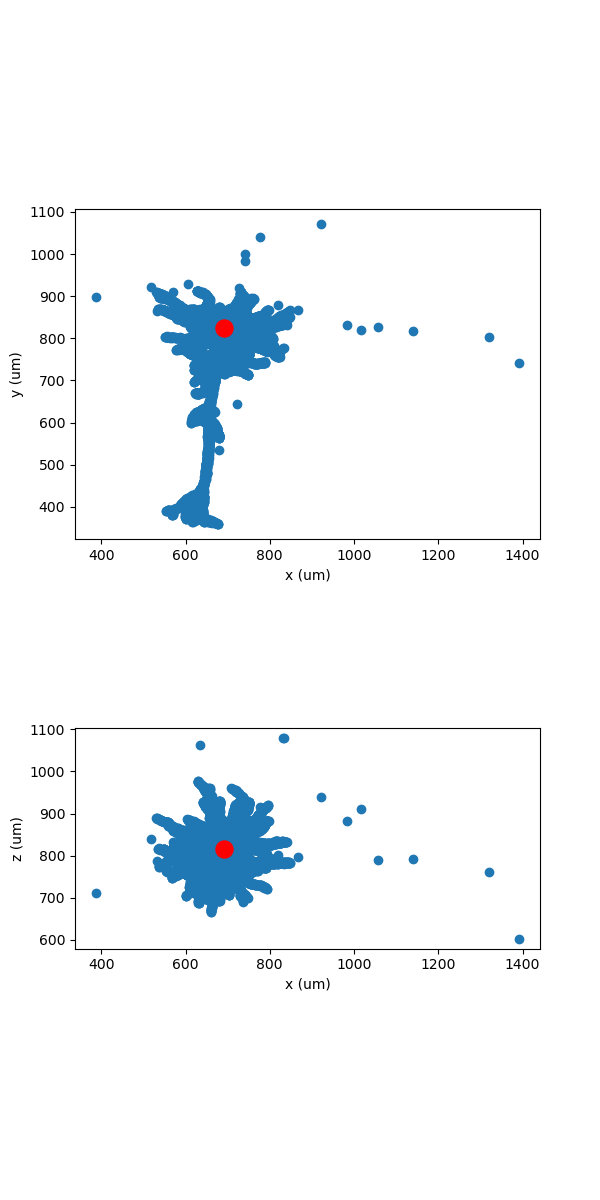

In [8]:
# Lets query this neuron, but now splitting columns and converting to um
post_synapse_df = client.materialize.synapse_query(post_ids = neuron_id,desired_resolution=(1000,1000,1000))

# Lets make a matrix of synapse positions for this neuron
syn_pos_nm = np.vstack(post_synapse_df['ctr_pt_position'].values)
# and plot their positions in x,y along with the soma position as a red circle
fig = plt.figure(figsize=(6,12))
ax1 = fig.add_subplot(2, 1, 1, aspect='equal')
ax2 = fig.add_subplot(2, 1, 2,  aspect='equal')
ax1.scatter(syn_pos_nm[:,0], syn_pos_nm[:,1])

# add the soma position as a red circle
soma_pos_df = clean_neuron_df.query(f'pt_root_id=={neuron_id}')
soma_pos = soma_pos_df['pt_position'].values
soma_pos = soma_pos[0]
ax1.scatter(soma_pos[0]*4/1000,soma_pos[1]*4/1000,c='r',s=150)
ax1.set_xlabel('x (um)')
ax1.set_ylabel('y (um)')
#ax1.set_ylim(1100,300)

ax2.scatter(syn_pos_nm[:,0], syn_pos_nm[:,2])

# add the soma position as a red circle
ax2.scatter(soma_pos[0]*4/1000,soma_pos[2]*40/1000,c='r',s=150)
ax2.set_xlabel('x (um)')
ax2.set_ylabel('z (um)')
plt.subplots_adjust(hspace=0.01)

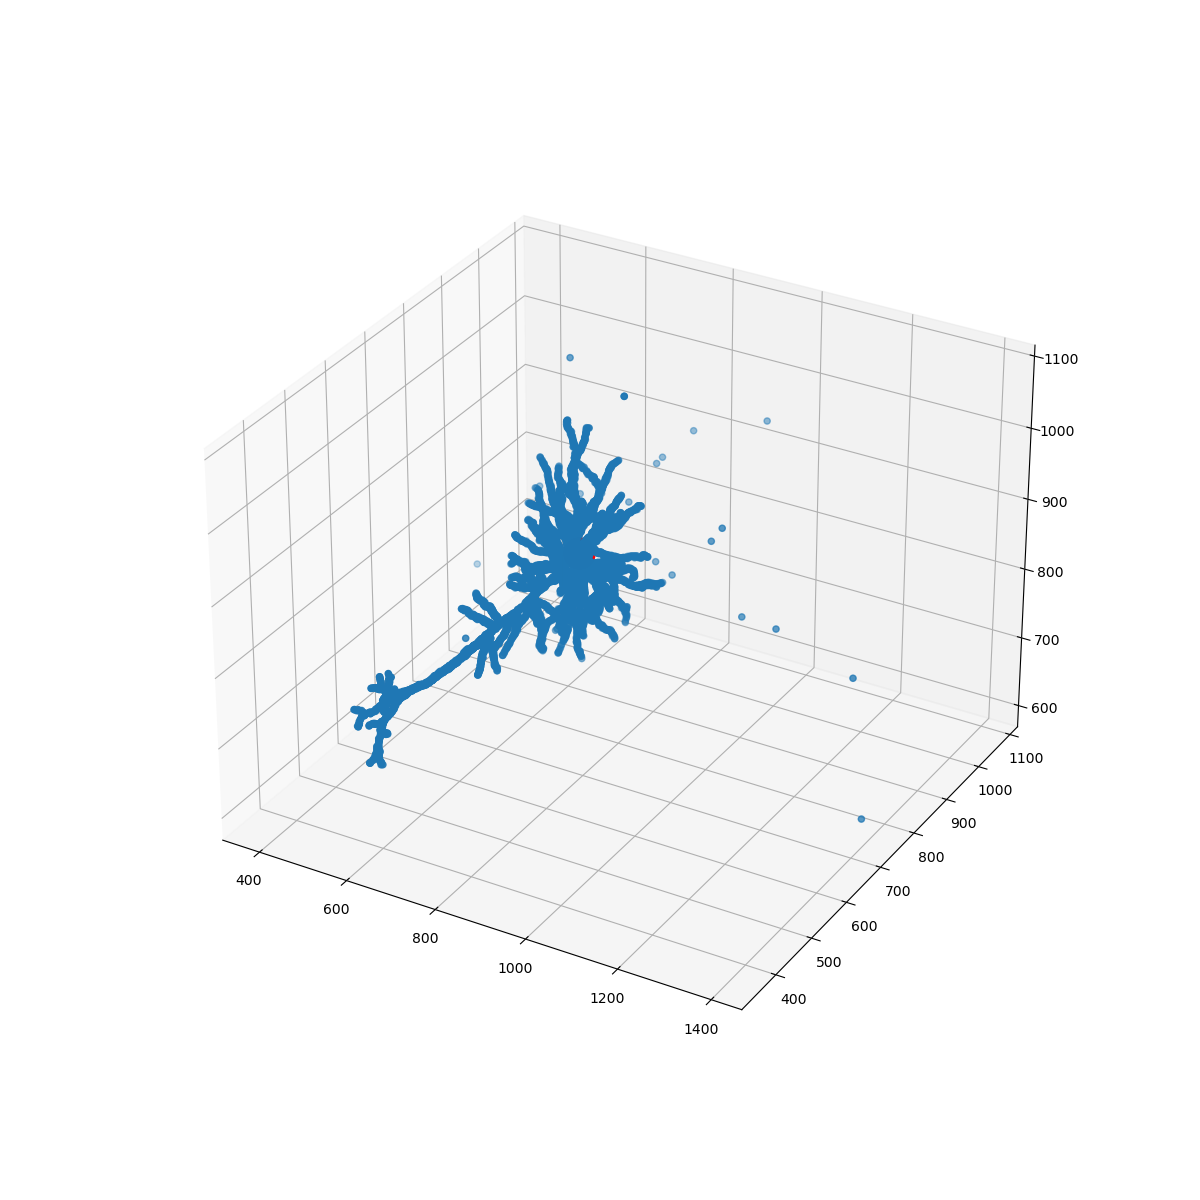

In [9]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1, projection='3d')


ax.scatter3D(syn_pos_nm[:,0], syn_pos_nm[:,1], syn_pos_nm[:,2])

# add the soma position as a red circle
ax.scatter3D(soma_pos[0]*4/1000,soma_pos[1]*4/1000,soma_pos[2]*40/1000,c='r',s=500)
plt.subplots_adjust(hspace=0.01)

In [10]:
neuron_soma_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117')
neuron_soma_df.head()

,id,valid,target_id,classification_system,cell_type,id_ref,valid__ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,553,t,498173,aibs_neuronal,6P-IT,498173,t,308.176159,103884538719281829,864691136091295156,"[284688, 211936, 15566]","[nan, nan, nan]","[nan, nan, nan]"
1,4509,t,487329,aibs_neuronal,MC,487329,t,295.937638,105279407463397326,864691135975935434,"[294544, 118624, 21745]","[nan, nan, nan]","[nan, nan, nan]"
2,4693,t,106662,aibs_neuronal,23P,106662,t,230.148178,79524515478544304,864691136084076652,"[107056, 119248, 19414]","[nan, nan, nan]","[nan, nan, nan]"
3,5061,t,271350,aibs_neuronal,6P-CT,271350,t,305.328128,87351114324194368,864691135937342005,"[163920, 235968, 20875]","[nan, nan, nan]","[nan, nan, nan]"
4,8652,t,456040,aibs_neuronal,MC,456040,t,257.463910,101129507251445952,864691136084057196,"[264544, 132528, 23988]","[nan, nan, nan]","[nan, nan, nan]"


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Skeleton Properties

To plot this skeleton in a more sophisticated way, you have to start thinking
of it as a graph, and the meshwork object has a bunch of tools and properties to help you
utilize the skeleton graph.

Let's list some of the most useful ones below </br>
You access each of these with nrn.skeleton.*</br>
Use the ? to read more details about each one

## properties
* **branch_points**: a list of skeleton vertices which are branches
* **root**: the skeleton vertice which is the soma
* **distance_to_root**: an array the length of vertices which tells you how far away from the root each vertex is
* **root_position**: the position of the root node in nanometers
* **end_points**: the tips of the neuron
* **cover_paths**: a list of arrays containing vertex indices that describe individual paths that in total cover the neuron without repeating a vertex. Each path starts at an end point and continues toward root, stopping once it gets to a vertex already listed in a previously defined path. Paths are ordered to start with the end points farthest from root first. Each skeleton vertex appears in exactly one cover path. 
* **csgraph**: a scipy.sparse.csr.csr_matrix containing a graph representation of the skeleton. Useful to do more advanced graph operations and algorithms. https://docs.scipy.org/doc/scipy/reference/sparse.csgraph.html
* **kdtree**: a scipy.spatial.ckdtree.cKDTree containing the vertices of skeleton as a kdtree. Useful for quickly finding points that are nearby. https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html

## methods
* **path_length(paths=None)**: the path length of the whole neuron if no arguments, or pass a list of paths to get the path length of that. A path is just a list of vertices which are connected by edges.
* **path_to_root(vertex_index)**: returns the path to the root from the passed vertex
* **path_between(source_index, target_index)**: the shortest path between the source vertex index and the target vertex index
* **child_nodes(vinds)**: a list of arrays listing the children of the vertex indices passed in
* **parent_nodes(vinds)**: an array listing the parent of the vertex indices passed in
* **

In [11]:
# import neuron as skeleton - check how many morphological properties can be applied
from meshparty import meshwork

# the files are named according to the segid and the nucleus_id of each cell
# this is to keep things straight for us as there are often many versions of 
# the same nucleus during proofreading. 
# so lets look up the nuc_id of our neuron

nuc_id=neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values[0]
mesh_filename = f"{neuron_id}_{nuc_id}.h5"
nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_filename))

In [12]:
mesh_filename

'864691135991773633_267029.h5'

In [13]:
#lvl2 ids : looking at lvl2 mesh for vol prop directly
nrn.anno.lvl2_ids

                  lvl2_id  mesh_ind  mesh_ind_filt
0      148781584344941385         0              0
1      148851953089119009         1              1
2      148922321833296698         2              2
3      148992690577474507         3              3
4      149063059321652265         4              4
...                   ...       ...            ...
16580  190234823120388172     16580          16580
16581  190234891839864863     16581          16581
16582  190305191864565880     16582          16582
16583  190305260584042551     16583          16583
16584  190305260584042571     16584          16584

[16585 rows x 3 columns]

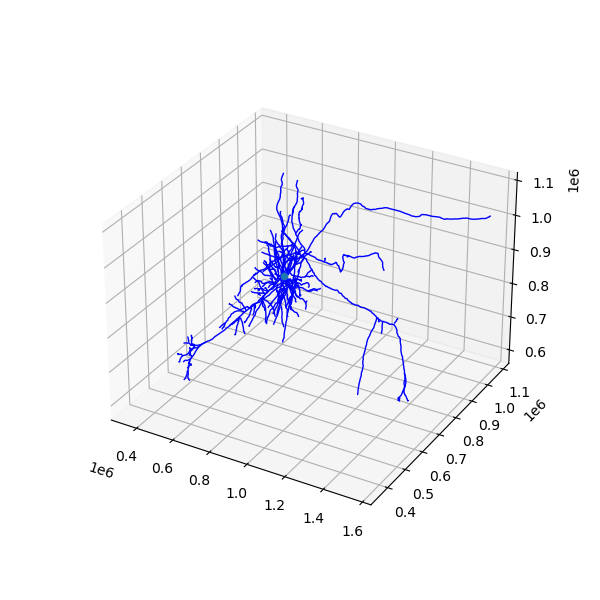

In [14]:
# So a better way to plot a neuron is to use cover_paths
# and plot those as 3d lines
def plot_neuron_skeleton(neuron, ax, c='b', linewidth=1):

    for cover_path in neuron.skeleton.cover_paths:
        path_verts = neuron.skeleton.vertices[cover_path,:]
        ax.plot(path_verts[:,0], path_verts[:,1], path_verts[:,2], c=c, linewidth=linewidth)

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')   
ax.scatter3D(nrn.skeleton.vertices[nrn.skeleton.root][0], nrn.skeleton.vertices[nrn.skeleton.root][1], nrn.skeleton.vertices[nrn.skeleton.root][2])
plot_neuron_skeleton(nrn, ax)

In [15]:
dendrite_mask = ~nrn.anno.is_axon.mesh_mask
seg_df = nrn.anno.segment_properties.filter_query(dendrite_mask).df

In [16]:
seg_gdf = seg_df.groupby("seg_num").agg(lambda x: x.iloc[0])

In [17]:
seg_gdf

,area,area_factor,is_root,len,mesh_ind,r_eff,strahler,vol,mesh_ind_filt
seg_num,,,,,,,,,
7,882602560,2.258281,False,154123.203125,245,403.588899,1,78867182080,245
8,595214912,2.144715,False,121406.429688,266,363.816658,1,50484344320,266
10,692120384,2.235224,False,123714.078125,274,398.347004,1,61672578560,274
11,101932480,1.699999,False,27262.910156,370,350.035290,1,10494113280,370
12,534118080,2.083982,False,114602.000000,397,355.935522,1,45612590080,397
...,...,...,...,...,...,...,...,...,...
268,121609664,1.878327,False,38119.152344,12951,270.317284,1,8750658560,12951
269,211327360,2.053156,False,54194.363281,13027,302.273293,1,15556200960,13027
271,195169216,2.087165,False,51930.296875,13944,286.585327,1,13399191040,13944


In [18]:
# avoid segment map - workflow:
#branch_children=nrn.skeleton.child_nodes(nrn.skeleton.branch_points)
#branch_parents=nrn.skeleton.parent_nodes(nrn.skeleton.branch_points)
#for par in branch_parents.to_mesh_region:
#    seg=nrn.anno.segment_properties.filter_query(par.to_mesh_mask).df

In [19]:
nrn.skeleton.branch_points

JointSkeletonIndex([  27,   73,  415,  641,  774,  785,  901,  903,  993,
                    1077, 1265, 1315, 1354, 1389, 1453, 1519, 1576, 1579,
                    1593, 1616, 1623, 1823, 1899, 1924, 1980, 2072, 2138,
                    2144, 2145, 2221, 2232, 2256, 2297, 2394, 2397, 2471,
                    2478, 2638, 2678, 2753, 2755, 2778, 2781, 2788, 2828,
                    2873, 2878, 2885, 2895, 2937, 3000, 3037, 3046, 3067,
                    3095, 3096, 3178, 3282, 3354, 3355, 3364, 3369, 3371,
                    3372, 3380, 3384, 3386, 3389, 3393, 3402, 3417, 3418,
                    3441, 3453, 3457, 3463, 3491, 3504, 3558, 3560, 3563,
                    3576, 3624, 3634, 3696, 3702, 3725, 3737, 3743, 3779,
                    3828, 3873, 3879, 3915, 3956, 3990, 4059, 4062, 4075,
                    4088, 4131, 4293, 4380, 4389, 4526, 4530, 4560, 4562,
                    4567, 4601, 4619, 4622, 4643, 4666, 4736, 4882, 4951,
                    5103, 5104, 5111, 

In [20]:
# avoid segment map - workflow:
# test
upstream_radii = []
upstream_info = []
downstream_info = []
downstream_radii = []
upstream_area_factor = []
downstream_area_factor = []
branch_children=nrn.skeleton.child_nodes(nrn.skeleton.branch_points)
branch_parents=nrn.skeleton.parent_nodes(nrn.skeleton.branch_points)
for par in branch_parents.to_mesh_region:
    seg=nrn.anno.segment_properties.filter_query(par.to_mesh_mask).df
    #seg.drop_duplicates(subset = ["area"])
    upstream_info.append(seg)
    upstream_radii.append(seg.r_eff.unique())
    upstream_area_factor.append(seg.area_factor.unique())
for child in branch_children:
    seg=nrn.anno.segment_properties.filter_query(child.to_mesh_mask).df
    #seg.drop_duplicates(subset = ["area"])
    downstream_info.append(seg)
    downstream_radii.append(seg.r_eff.unique())
    downstream_area_factor.append(seg.area_factor.unique())

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [56]:
# iterate over all branching points to get upstream and downstream radii
# Sven's old code to look at missing segments
'''
upstream_radii = []
downstream_radii = []
for bpind,bp in enumerate(nrn.skeleton.branch_points):
    upstream_branch_list = nrn.skeleton.segment_map[nrn.skeleton.parent_nodes(bp)]
    downstream_branch_list = nrn.skeleton.segment_map[nrn.skeleton.child_nodes(bp)]
    
    try:
        upstream_radii_ = seg_gdf.loc[upstream_branch_list].r_eff
        downstream_radii_ = list(seg_gdf.loc[downstream_branch_list].r_eff)
    except KeyError:
        #print(bpind)
        print(bp)
        continue
    
    upstream_radii.append(upstream_radii_)
    downstream_radii.append(downstream_radii_)
    '''

27
73
641
774
2873
3417
3418
3725
3779
3915
3990
4059
4062
4131
4389
4526
4560
4562
4567
4619
4622
4643
5673
6296
6630
7039
7054
7108
7172
7353
7418
7503


In [21]:
upstream_filt = [x for i,x in enumerate(upstream_radii) if x]
upstream_inds = [i for i,x in enumerate(upstream_radii) if x]

/tmp/ipykernel_9880/2603269250.py:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  upstream_filt = [x for i,x in enumerate(upstream_radii) if x]
/tmp/ipykernel_9880/2603269250.py:2: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  upstream_inds = [i for i,x in enumerate(upstream_radii) if x]


In [22]:
# create sq sum array of downstream radii

def getSumDS(upstream_filt,downstream_radii,a):
    sumds = np.zeros((len(upstream_filt),1))
    inds = 0
    for i in range(len(upstream_radii)):
        if (i in upstream_inds):
            sumds[inds] = np.sum((np.array(downstream_radii[inds])/1000)**a)
            inds = inds+1
    return sumds

In [23]:
len(upstream_filt)

131

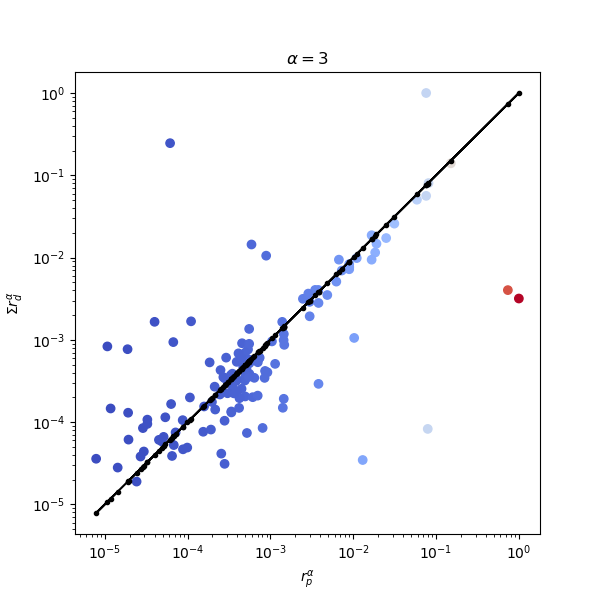

In [24]:
# scatter upstream and downstream radii ^2 etc
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
a = 3
sumds = getSumDS(upstream_filt,downstream_radii,a)
maxUS = np.max((np.array(upstream_filt)/1000)**a)
ax.scatter((np.array(upstream_filt)/1000)**a/maxUS, sumds/maxUS,c=np.array(upstream_filt)/1000,cmap='coolwarm')
ax.plot((np.array(upstream_filt)/1000)**a/maxUS, (np.array(upstream_filt)/1000)**a/maxUS, 'k.-')
ax.set_ylabel(r'$\Sigma r_d^{\alpha}$')
ax.set_xlabel(r'$r_p^{\alpha}$')
ax.set_title(r'$\alpha =$' + str(a))
ax.set_yscale('log')
ax.set_xscale('log')
#plt.coolwarm()
#ax.scatter(np.array(upstream_radii)/1000, sumds)

In [25]:
# Question - how to account for area factor while looking at area scaling? 
# normalize by area factor and plot? 


In [60]:
# Other morphology questions:
# get 0th level axis and get +/- 45 degree slices 
# - Sum over lengths of segments in a given +/- 45deg area along the axis of highest variation 
# - length over branching pts and length/syn density for these areas


In [229]:
# function to convert xz space coordinates to radial coordinates
def convertToRadial(xz):
    # xz coordinates : 2D projection coordinates in x-z plane
    r = np.sqrt(xz[:,0]**2 + xz[:,1]**2)
    theta = np.arctan2(xz[:,1], xz[:,0])
    return np.column_stack((r,theta))

In [230]:
def getRadialCoord(skel_pos, soma_pos): 
    skel_pos_wrtsoma = skel_pos - soma_pos
    skel_pos_wrtsoma_xz = np.column_stack((skel_pos_wrtsoma[:,0],skel_pos_wrtsoma[:,2]))
    # convert to radial positions - only extract x-z plane positions
    skel_pos_radial = convertToRadial(skel_pos_wrtsoma_xz)
    
    # get major axis coordinates
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X = skel_pos_wrtsoma_xz
    X = (X-np.mean(X,axis = 0))
    pca.fit(X);
    majorAxis = pca.components_[0]
    
    majorAxisAngle = np.arctan2(majorAxis[1],majorAxis[0])
    # get radial coordinates with shifted axis wrt majorAxis determined
    theta = majorAxisAngle
    rotMat = np.array([[np.cos(theta), -np.sin(theta)],
               [np.sin(theta), np.cos(theta)]])
    skel_pos_transformed = rotMat @ skel_pos_wrtsoma_xz.T
    skel_pos_transformed = (skel_pos_transformed).T

    skel_pos_radial_transformed = convertToRadial(skel_pos_transformed)
    
    return skel_pos_radial, majorAxis, skel_pos_transformed, skel_pos_radial_transformed

In [231]:
def getAngularDensity(skel_pos_radial_transformed,weights_to_sum,majorAxis,angle):
    # get density of cable (weights_to_sum) etc +/- angle from major axis
    # effectively - we want points with theta values either +angle/2, -angle/2, pi-angle/2, -pi+angle/2
    skel_in_range_mask = (((skel_pos_radial_transformed[:,1] < angle/2) & (skel_pos_radial_transformed[:,1] > -angle/2)) | ((skel_pos_radial_transformed[:,1] > np.pi-(angle/2)) & (skel_pos_radial_transformed[:,1] < np.pi)) | ((skel_pos_radial_transformed[:,1] < -np.pi+(angle/2)) & (skel_pos_radial_transformed[:,1] > -np.pi)))
    skel_in_range = skel_pos_radial_transformed[skel_in_range_mask]    
    withinAngle = np.sum(weights_to_sum[skel_in_range_mask])
    outsideAngle = np.sum(weights_to_sum[~skel_in_range_mask])
    angularRatio = withinAngle/outsideAngle
    
    return angularRatio, withinAngle, skel_in_range_mask
    

In [232]:
# get coordinates of skeleton wrt the soma 
skeleton_vertices = nrn.skeleton.vertices
nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
skeleton_pos_wrtsoma = skeleton_vertices - nrn_somapos

skel_pos_radial, majorAxis, skel_pos_transformed, skel_pos_radial_transformed = getRadialCoord(skeleton_vertices, nrn_somapos)

In [233]:
skel_pos_transformed.shape

(7504, 2)

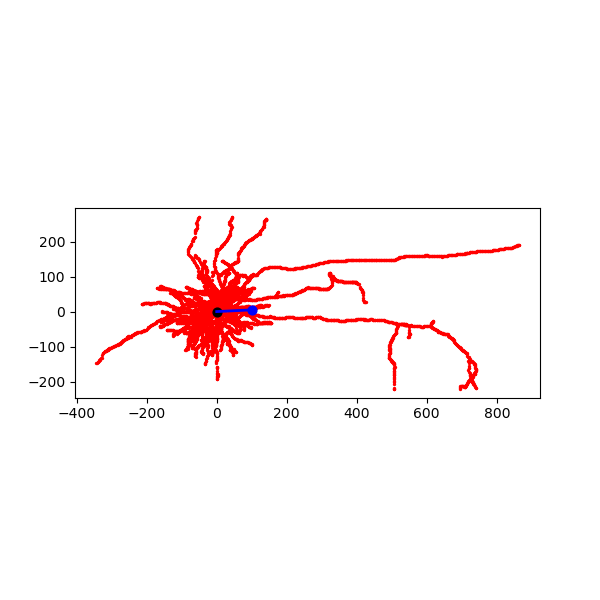

In [234]:
# plot pca vectors along with the data points
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()   

ax.scatter(skeleton_pos_wrtsoma[:,0]/1000,skeleton_pos_wrtsoma[:,2]/1000,s=2,color='r')
ax.plot([0,majorAxis[0]*100],[0,majorAxis[1]*100],linewidth=2,color='b') 
ax.scatter(majorAxis[0]*100,majorAxis[1]*100,s=40,color='b') 
ax.scatter(0,0,s=40,color='k')
ax.set_aspect('equal')

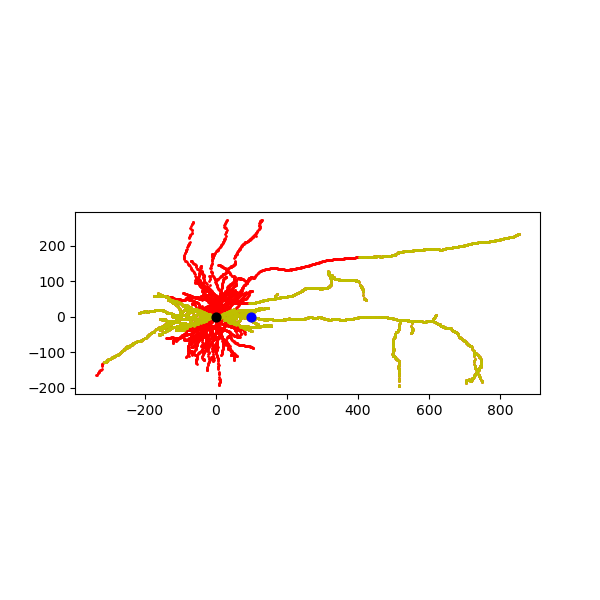

In [238]:
# plot pca vectors along with the data points
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()   

ax.scatter(skel_pos_transformed[:,0]/1000,skel_pos_transformed[:,1]/1000,s=1,color='r')
ax.scatter(skel_pos_transformed[skelids,0]/1000,skel_pos_transformed[skelids,1]/1000,s=1,color='y')
ax.scatter(0,0,s=40,color='k')
ax.scatter(100,0,s=40,color='b')
ax.set_aspect('equal')

In [236]:
angularRatio, withinAngle, skel_in_range_mask = getAngularDensity(skel_pos_radial_transformed,np.ones_like(skel_pos_radial_transformed),majorAxis,np.pi/4)

In [239]:
skelids = np.array(np.where(skel_in_range_mask))
allskelids = np.arange(len(skel_pos_transformed))
skeletoninds = nrn.skeleton.SkeletonIndex(skelids)
allSkelInds = nrn.skeleton.SkeletonIndex(allskelids)

In [240]:
meshMaskReq = (skeletoninds.to_mesh_mask & dendrite_mask)
segdf = nrn.anno.segment_properties.filter_query(meshMaskReq).df

In [241]:
weights_to_sum = segdf.len.values

In [242]:
meshMaskAll = (allSkelInds.to_mesh_mask & dendrite_mask)
segdf = nrn.anno.segment_properties.filter_query(meshMaskAll).df
allWeights = segdf.len.values

In [243]:
weights_to_sum.sum()/allWeights.sum()

0.2933221338534465

In [244]:
dendrite_mask = ~nrn.anno.is_axon.mesh_mask
seg_df = nrn.anno.segment_properties.filter_query(dendrite_mask).df